In [53]:
import numpy as np
import math
import matplotlib.pyplot as plt
import mode_analysis_code_original as ma

#create 3d array to hold data [ [ [x_p1_t0, x_p2_t0, x_p3_t0, ...],[y_p1_t0, y_p2_t0, ...], ... ],
#                              [ [x_p1_t1, x_p2_t1, x_p3_t1, ...],[y_p1_t1, y_p2_t1, ...], ... ],
#                                 . . .
#                              [ [x_p1_tn, x_p2_tn, x_p3_tn, ...],[y_p1_tn, y_p2_tn, ...], ... ] ]



#Open the binary file for reading
f = open("output.dat", "rb")


########## read number of particles (first number in data file) ##########
char_len = 1
char_empty = False
while not char_empty:
    f.seek(0)  #go to first character in file
    data_byte = f.read(char_len)
    num_particles = int(data_byte)
    char_len+=1
    next_char = f.read(1)
    if next_char ==  b" ":
        char_empty = True
        
print("Num particles: " + str(num_particles))

########## read number of timesteps ##########
steps = float(f.read(12))  #non-negative number in scientific notation has 12 characters
steps = int(steps)
print("Number of steps: " + str(steps))

f.read(1)  #read and ignore space

########## read write rate ##########
write_per = float(f.read(12))  #non-negative number in scientific notation has 12 characters
write_per = int(write_per)
print("Write per: " + str(write_per))

f.read(1)  #read and ignore space

########## read duration ##########
duration = float(f.read(12))
print("Simulation duration: " + str(duration))

f.read(1)

########## read timestep ##########
dt = float(f.read(12))
print("Timestep: " + str(dt))

f.read(1)

########## read axial magnetic field ##########
data_byte = f.read(13) 
if float(data_byte) >= 0:  #if value is non-negative, only read 12 characters
    f.seek(-13,1)
    data_byte = f.read(12)
    Bz = float(data_byte)
else:  #if value is negative, read 13 characters
    Bz = float(data_byte)
f.read(1)

########## read k_z ##########
data_byte = f.read(13)
if float(data_byte) >= 0:
    f.seek(-13,1)
    data_byte = f.read(12)
    kz = float(data_byte)
else:
    kz = float(data_byte)
f.read(1)

########## read delta ##########
data_byte = f.read(13)
if float(data_byte) >= 0:
    f.seek(-13,1)
    data_byte = f.read(12)
    delta = float(data_byte)
else:
    delta = float(data_byte)
f.read(1)

########## read omega_R ##########
data_byte = f.read(13)
if float(data_byte) >= 0:
    f.seek(-13,1)
    data_byte = f.read(12)
    omegaR = float(data_byte)
else:
    omegaR = float(data_byte)
f.read(1)

########## read phi_0 ##########
data_byte = f.read(13)
if float(data_byte) >= 0:
    f.seek(-13,1)
    data_byte = f.read(12)
    phi0 = float(data_byte)
else:
    phi0 = float(data_byte)
f.read(1)

print("Bz: " + str(Bz))
print("kz: " + str(kz))
print("delta: " + str(delta))
print("phi0: " + str(phi0))

########## read charges ##########
charges = np.array([])
for i in range(num_particles):
    data_byte = f.read(13)
    if float(data_byte) >= 0:
        f.seek(-13,1)
        data_byte = f.read(12)
        this_charge = float(data_byte)
        charges = np.append(charges, this_charge)
    else:
        this_charge = float(data_byte)
        charges = np.append(charges, this_charge)
    f.read(1)
    
########## read masses ##########
masses = np.array([])
for i in range(num_particles):
    data_byte = f.read(13)
    if float(data_byte) >= 0:
        f.seek(-13,1)
        data_byte = f.read(12)
        this_mass = float(data_byte)
        masses = np.append(masses, this_mass)
    else:
        this_mass = float(data_byte)
        masses = np.append(masses, this_mass)
        print("ERROR: NEGATIVE MASS")
    f.read(1)

print("Charges:")
print(charges)
print("Masses:")
print(masses)

####### beam parameters ############
char_len = 1
char_empty = False
num_beams_pos = f.tell()
while not char_empty:
    f.seek(num_beams_pos)  #go to first digit in num_beams
    data_byte = f.read(char_len)
    num_beams = int(data_byte)
    char_len+=1
    next_char = f.read(1)
    if next_char ==  b" ":
        char_empty = True
        
beam_S0 = np.array([]) #peak intensity
beam_khat = np.empty([3,num_beams]) #khat vectors of beams
beam_waist = np.array([]) #beam waists, -1 signifies uniform beam
beam_disp = np.empty([3, num_beams]) #beam displacement from origin
beam_det = np.array([]) #beam detuning from atomic transition

for i in range(num_beams):
    data_byte = f.read(13)
    if float(data_byte) >= 0:
        f.seek(-13,1)
        data_byte = f.read(12)
        this_S0 = float(data_byte)
        beam_S0 = np.append(beam_S0, this_S0)
    else:
        this_S0 = float(data_byte)
        beam_S0 = np.append(beam_S0, this_S0)
        print("ERROR: NEGATIVE INTENSITY")
    f.read(1)
    

for j in range(3):
    for i in range(num_beams):
        data_byte = f.read(13)
        if float(data_byte) >= 0:
            f.seek(-13,1)
            data_byte = f.read(12)
            this_k = float(data_byte)
            beam_khat[j][i] = this_k
        else:
            this_k = float(data_byte)
            beam_khat[j][i] = this_k
        f.read(1)
beam_khat = np.transpose(beam_khat)  #the ith row corresponds to the components of the khat vector for ith ion

for i in range(num_beams):
    data_byte = f.read(13)
    if float(data_byte) >= 0:
        f.seek(-13,1)
        data_byte = f.read(12)
        this_waist = float(data_byte)
        beam_waist = np.append(beam_waist, this_waist)
    else:
        this_waist = float(data_byte)
        beam_waist = np.append(beam_waist, this_waist)
    f.read(1)
'''
for i in range(num_beams):
    data_byte = f.read(13)
    if float(data_byte) >= 0:
        f.seek(-13,1)
        data_byte = f.read(12)
        this_disp = float(data_byte)
        beam_disp = np.append(beam_disp, this_disp)
    else:
        this_disp = float(data_byte)
        beam_disp = np.append(beam_disp, this_disp)
    f.read(1)'''
    
for j in range(3):
    for i in range(num_beams):
        data_byte = f.read(13)
        if float(data_byte) >= 0:
            f.seek(-13,1)
            data_byte = f.read(12)
            this_disp = float(data_byte)
            beam_disp[j][i] = this_disp
        else:
            this_disp = float(data_byte)
            beam_disp[j][i] = this_disp
        f.read(1)
beam_disp = np.transpose(beam_disp)  #the ith row corresponds to the components of the displacement vector for ith ion
    
for i in range(num_beams):
    data_byte = f.read(13)
    if float(data_byte) >= 0:
        f.seek(-13,1)
        data_byte = f.read(12)
        this_det = float(data_byte)
        beam_det = np.append(beam_det, this_det)
    else:
        this_det = float(data_byte)
        beam_det = np.append(beam_det, this_det)
    f.read(1)

print("Num beams: " + str(num_beams))
print("S0:")
print(beam_S0)
print("khat:")
print(beam_khat)
print("waist:")
print(beam_waist)
print("displacement:")
print(beam_disp)
#print(beam_disp[2][2])
print("detuning:")
print(beam_det)


############################## READ POS. & VEL. AT EACH TIMESTEP ##############################

time_counter = 0  #outermost index of data array, indexes timestep
type_counter = 0  #middle index which tells us to go to i.e. x positions array, or y velocities array, etc
val_counter = 0  #innermost index, indexes particle

times_rec = int((steps-1)/write_per)+2
data = np.zeros((times_rec,6,num_particles))

while time_counter < times_rec:
    #read data for this timestep
    type_array = np.zeros((6, num_particles))  #has form [ [x_p1_t0, x_p2_t0, x_p3_t0, ...],[y_p1_t0, y_p2_t0, ...], ... ]
    while type_counter < 6:
        #for this data type, i.e. y-velocities, read data for each particle
        val_array = np.array([])  #has form [x_p1_t0, x_p2_t0, x_p3_t0, ...]
        while val_counter < num_particles:
            data_byte = f.read(13)
            #print(data_byte)
            if float(data_byte) >= 0 and str(float(data_byte))[0] != '-': #second coniditon is for -0.0e00
                #print(str(float(data_byte)))
                f.seek(-13,1)
                data_byte = f.read(12)
            
            this_val = float(data_byte)
            val_array = np.append(val_array, this_val)

            f.seek(1,1) #skip the space between values
            val_counter+=1
            
        type_array[type_counter] = val_array
        val_counter = 0
        type_counter+=1
    data[time_counter] = type_array
    type_counter=0
    time_counter+=1
    
print(data)
print(data.shape)
x_save = data[:,0,:]
z_save = data[:,2,:]
vx_save = data[:,3,:]
vz_save = data[:,5,:]

np.savetxt("x_sim.csv", x_save, delimiter = ' ')
np.savetxt("z_sim.csv", z_save, delimiter = ' ')
np.savetxt("vx_sim.csv", vx_save, delimiter = ' ')
np.savetxt("vz_sim.csv", vz_save, delimiter = ' ')


Num particles: 512
Number of steps: 10000
Write per: 2
Simulation duration: 1e-05
Timestep: 1e-09
Bz: 4.4588
kz: 9205570.0
delta: 0.001751114
phi0: 1.570796
Charges:
[1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.

[[[-5.362521e-07 -6.359926e-08  1.030271e-05 ...  1.361410e-04
   -1.498520e-04  7.855664e-05]
  [-4.062062e-07  1.121130e-05  4.436156e-06 ...  3.056523e-05
   -3.153749e-05 -1.413679e-04]
  [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
    0.000000e+00  0.000000e+00]
  [ 4.594083e-01 -1.267968e+01 -5.017175e+00 ... -3.456847e+01
    3.566806e+01  1.598833e+02]
  [-6.064868e-01 -7.192906e-02  1.165209e+01 ...  1.539719e+02
   -1.694787e+02  8.884546e+01]
  [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
    0.000000e+00  0.000000e+00]]

 [[-5.353320e-07 -8.895620e-08  1.029265e-05 ...  1.360715e-04
   -1.497803e-04  7.887618e-05]
  [-4.074180e-07  1.121113e-05  4.459447e-06 ...  3.087307e-05
   -3.187634e-05 -1.411899e-04]
  [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
    0.000000e+00  0.000000e+00]
  [ 4.607743e-01 -1.267949e+01 -5.043427e+00 ... -3.491545e+01
    3.604999e+01  1.596827e+02]
  [-6.054498e-01 -1.005091e-01  1.164076e+01 ...

Final velcoity in z-direction: -0.4349198


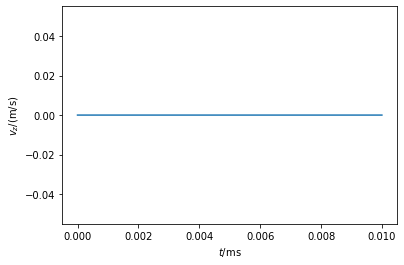

In [54]:
%matplotlib inline
times = []
for i in range(len(data)):
    times.append(i*write_per*dt)
plt.figure()
plt.plot(1.0e3 * np.array(times[:]), data[:,5,1])
plt.xlabel(r'$t/\rm{ms}$')
plt.ylabel(r'$v_z/(\rm{m}/\rm{s})$')
print("Final velcoity in z-direction: " + str(data[-1,3,0]))

In [55]:
#transform x and y coordinates to rotating frame

start_step = 0
end_step = times_rec
print(omegaR/(2*np.pi))
pos_rot = np.empty((end_step-start_step+1, 2, num_particles))
for i in range(start_step, end_step):
    this_x = np.array([])
    this_y = np.array([])
    for j in range(num_particles):
        xx = np.cos(omegaR*dt*i*write_per)*data[i,0,j]+np.sin(omegaR*dt*i*write_per)*data[i,1,j] #rotation
        yy = -np.sin(omegaR*dt*i*write_per)*data[i,0,j]+np.cos(omegaR*dt*i*write_per)*data[i,1,j] #rotation
        this_x = np.append(this_x, xx)
        this_y = np.append(this_y, yy)
    pos_rot[i-start_step,0] =this_x
    pos_rot[i-start_step,1] =this_y

179999.94345347016


Text(0, 0.5, '$v_x/(\\rm{m}/\\rm{s})$')

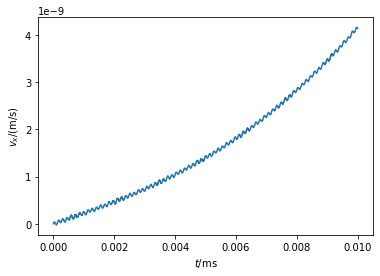

In [21]:
times = []
for i in range(len(data)):
    times.append(i*write_per*dt)
plt.figure()
plt.plot(1.0e3 * np.array(times[:]), pos_rot[:-1,0,1])
plt.xlabel(r'$t/\rm{ms}$')
plt.ylabel(r'$v_x/(\rm{m}/\rm{s})$')

0.0


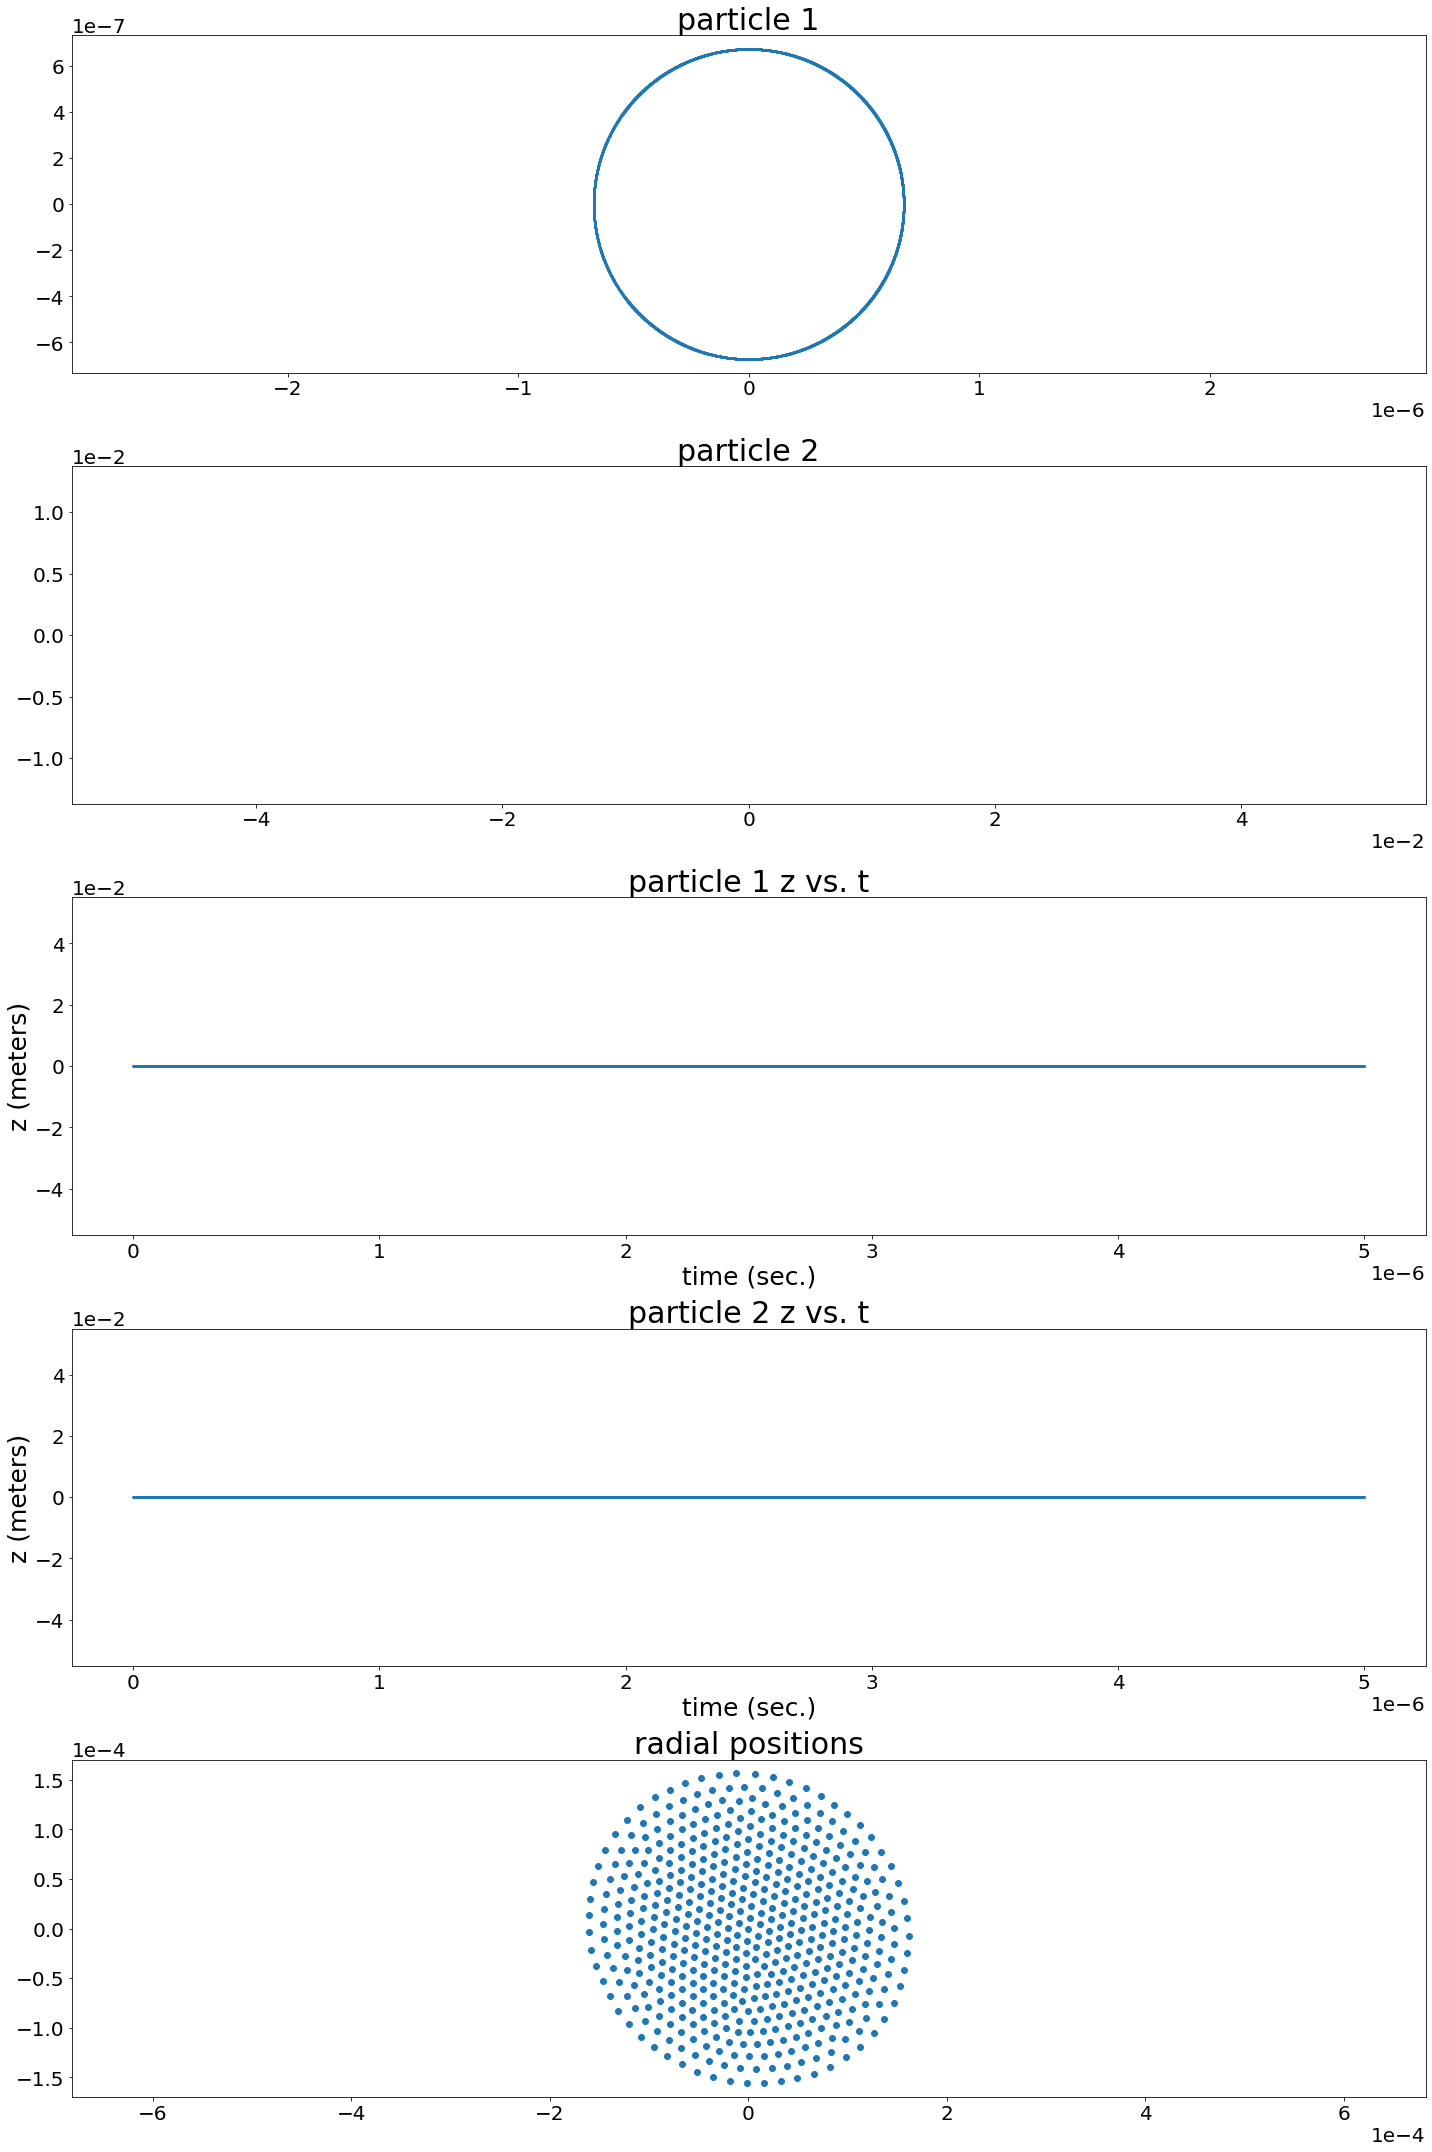

In [56]:
#some plots of particle motion in lab frame
%matplotlib inline

f, axs = plt.subplots(5,1,figsize=(20,30))

time = 450
axs[4].plot(data[time, 0, :], data[time, 1, :], 'o')
axs[4].axis('equal')
axs[4].set_title('radial positions', fontsize=30)
axs[4].tick_params(axis='both', labelsize=20)
axs[4].xaxis.offsetText.set_fontsize(20)
axs[4].yaxis.offsetText.set_fontsize(20)
axs[4].ticklabel_format(style='sci', scilimits = (0,0))

#plot y vs x for particle 1
axs[0].plot(data[:, 0, 0], data[:, 1, 0], '.', ms=3)
axs[0].axis('equal')
axs[0].set_title('particle 1', fontsize=30)
axs[0].tick_params(axis='both', labelsize=20)
axs[0].xaxis.offsetText.set_fontsize(20)
axs[0].yaxis.offsetText.set_fontsize(20)
axs[0].ticklabel_format(style='sci', scilimits = (0,0))

#plot y vs x for particle 2
axs[1].plot(data[10000:10500, 0, 1], data[10000:10500, 1, 1], '.', ms=3)
axs[1].axis('equal')
axs[1].set_title('particle 2', fontsize=30)
axs[1].tick_params(axis='both', labelsize=20)
axs[1].xaxis.offsetText.set_fontsize(20)
axs[1].yaxis.offsetText.set_fontsize(20)
axs[1].ticklabel_format(style='sci', scilimits = (0,0))

#plot z vs t for particle 1
axs[2].plot(dt*np.arange(len(data[:, 2, 0])), data[:, 2, 0], '.', ms=3)
#axs[2].axis('equal')
#axs[2].set_xlim(0,1e-05)
axs[2].set_title('particle 1 z vs. t', fontsize=30)
axs[2].set_xlabel('time (sec.)', fontsize=25)
axs[2].set_ylabel('z (meters)', fontsize=25)
axs[2].tick_params(axis='both', labelsize=20)
axs[2].xaxis.offsetText.set_fontsize(20)
axs[2].yaxis.offsetText.set_fontsize(20)
axs[2].ticklabel_format(style='sci', scilimits = (0,0))
print(min(data[:, 2, 0]))

#plot z vs t for particle 2
axs[3].plot(dt*np.arange(len(data[:, 2, 1])), data[:, 2, 1], '.', ms=3)
#axs[2].axis('equal')
#axs[3].set_xlim(0,1e-05)
axs[3].set_title('particle 2 z vs. t', fontsize=30)
axs[3].set_xlabel('time (sec.)', fontsize=25)
axs[3].set_ylabel('z (meters)', fontsize=25)
axs[3].tick_params(axis='both', labelsize=20)
axs[3].xaxis.offsetText.set_fontsize(20)
axs[3].yaxis.offsetText.set_fontsize(20)
axs[3].ticklabel_format(style='sci', scilimits = (0,0))

f.tight_layout()

plt.show()


In [13]:
#functions copied from crystal_mod to plot PSD

def psd(coord_traj,time_step,units=1e6,log=True):
    """computes the power spectrum of the coordianate trajectroy and converts the units of the frequecies from hertz
        default is MHz. Returns the log of the power spectrum by default, and the frequencies."""
    ps =  np.sum(np.abs(np.fft.fft(coord_traj,axis=0) / np.size(coord_traj[0,:]))**2, axis=1)
    freqs = np.fft.fftfreq(coord_traj[:,0].size, time_step)
    idx = np.argsort(freqs)
    freqs_norm=freqs[idx]/units
    if log == True:
        ps = np.log(ps[idx])
    return ps,freqs_norm

def plot_psd(freqs_norm,ps_log,ax,fig,
        title=None,label=None,normal_freqs=[],
        color='b'):
    if label==None: 
        label = 'PSD'
    if title ==None:
        title = 'Power Spectrum'
    ax.plot(freqs_norm, ps_log,label=label,color=color)
    if len(normal_freqs)!=0:
        switch = 0
        for norm_freq in normal_freqs:
            if switch == 0: 
                ax.axvline(x=norm_freq,color='r',label='Linear Modes'
                           ,alpha = 0.75,zorder = 1)
                switch += 1
            else: 
                ax.axvline(x=norm_freq,color='r',alpha = 0.75
                           ,zorder = 1)
        nf_min = np.min(normal_freqs);nf_max=np.max(normal_freqs)
        expand = .05*(nf_max - nf_min)
        ax.set_xlim(( nf_min-expand , nf_max+expand ))
    ax.set_ylim((-30, 0))
    ax.set_ylabel(r"$\ln(PSD)$ [A.U.]")
    ax.set_xlabel(r"Frequency [$MHz$]")
    ax.set_title(title)
    
def get_mode_ticks(labels,freqs,min_diff=0.05):
    assert len(labels)==len(freqs),"labels and freqs must be same length"
    diffs = np.diff(freqs)/(freqs[-1]-freqs[0])
    gdexs = np.append(np.where(diffs>min_diff),np.array([len(freqs)-1]))
    bdexs = np.array(np.where(diffs<=min_diff))
    tdexs = np.isin(gdexs,bdexs+1)
    fdexs = gdexs[np.where(np.logical_not(tdexs))]
    stops = gdexs[np.where(tdexs)]
    bgins = bdexs[np.where(np.isin(bdexs,gdexs+1))]
    assert len(bgins)==len(stops),'something went wrong'
    dexs  = np.append(gdexs,stops)
    freqs[stops] = (freqs[stops] + freqs[bgins])/2 
    labels[stops]  = [labels[bgins[i]]+'-'+labels[stops[i]] for i in range(len(bgins))]
    gfreqs = freqs[dexs] ; glabels = labels[dexs]
    return gfreqs,glabels 

/tmp/ipykernel_402449/487182422.py:11: RuntimeWarning: divide by zero encountered in log
  ps = np.log(ps[idx])
/tmp/ipykernel_402449/487182422.py:42: RuntimeWarning: invalid value encountered in true_divide
  diffs = np.diff(freqs)/(freqs[-1]-freqs[0])
/tmp/ipykernel_402449/487182422.py:43: RuntimeWarning: invalid value encountered in greater
  gdexs = np.append(np.where(diffs>min_diff),np.array([len(freqs)-1]))
/tmp/ipykernel_402449/487182422.py:44: RuntimeWarning: invalid value encountered in less_equal
  bdexs = np.array(np.where(diffs<=min_diff))


[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.25146481]


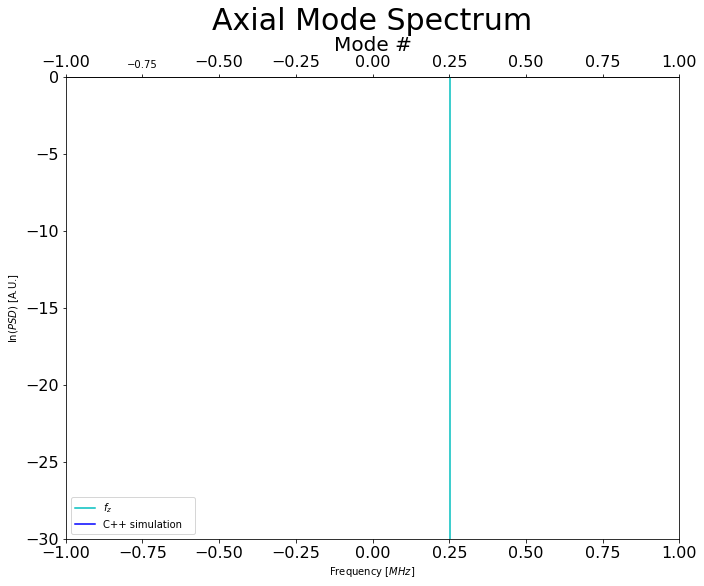

In [14]:
#Initialize mode analysis with same parameters as in set_parameters
num_ions=6
mass_amu=9.012182
vtrap=(0.0, -1750.0, -1970.0)
v_wall=1.
frot=180000
method='bfgs'
frot_kHz = 1e-3*frot 
units = 1e6
ma_instance=ma.ModeAnalysis(
            N      = num_ions,
            ionmass= mass_amu,
            Vtrap  = vtrap,
            Vwall  = v_wall,
            frot   = frot_kHz,
            method = method)
ma_instance.run()

wrot = ma_instance.wrot
wc   = ma_instance.wc*ma_instance.wz
wz   = ma_instance.wz
beta = ma_instance.beta 
cycprime   = wc - 2*wrot
omegaplus  = (np.sqrt(cycprime**2 + 4*beta*wz**2)+cycprime)/2
omegaminus = (np.sqrt(cycprime**2 + 4*beta*wz**2)-cycprime)/2


#Axial mode PSD
pos_ax = data[:,2,:]
ps_ax, freq_norm_ax = psd(pos_ax, dt)

all_normal_freqs = ma_instance.planarEvalsE/units/2/np.pi
ax_normal_freqs = ma_instance.axialEvalsE/units/2/np.pi

print(ax_normal_freqs)

fig = plt.figure(figsize=(11,8.5),constrained_layout=False)
gs  = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[:, :])



ax_modes = np.arange(0,num_ions)
normal_freqs = ax_normal_freqs[ax_modes]
ax1.axvline(ma_instance.wz/units/np.pi/2
            ,color='c'
            ,label=r'$f_z$'
            ,zorder=2)
plot_psd(freq_norm_ax,ps_ax,ax1,fig
        ,label='C++ simulation   '
        ,color='b'
        )    
ax1.fill_between(freq_norm_ax,ps_ax,-30
        ,color='b'
        ,zorder=3
        )

secax_x = ax1.secondary_xaxis('top')
secax_x.set_xlabel('Mode #',fontsize=20)
labels  = np.array(list(map(str, (ax_modes+1))),dtype='<U5')
freqs,labels = get_mode_ticks(labels,normal_freqs)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
secax_x.set_xticks(freqs) 
secax_x.set_xticklabels(labels,fontsize=16)
ax1.legend(loc='lower left')
ax1.set_title('Axial Mode Spectrum',fontsize=30)
ax1.set_xlim(-1,1)

plt.show()

[1.08817975e-06 1.70964253e-01 1.75836052e-01 2.59795064e-01
 2.60709744e-01 2.97700597e-01]
['1' '2' '3' '4' '5' '6']
[7.41317251 7.49810439 7.50263686 7.53509603 7.53987181 7.62870258]


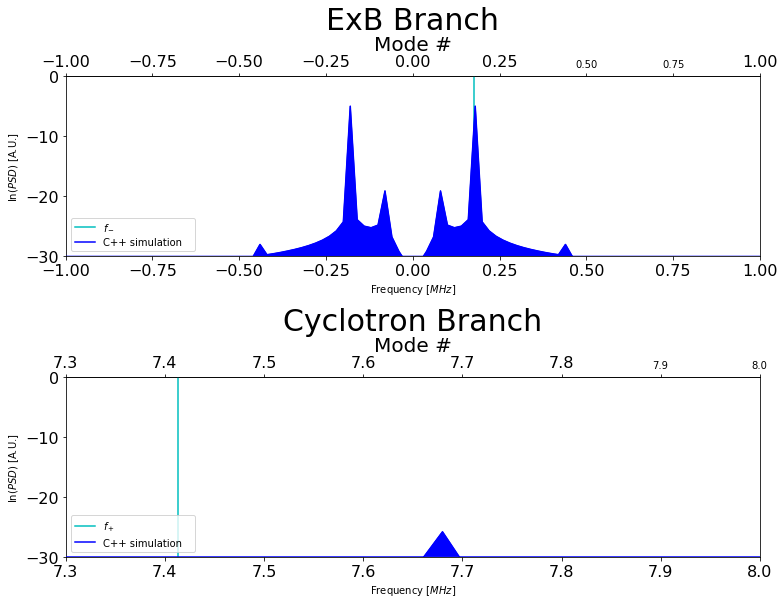

In [15]:
ps_rad,freq_norm_rad = psd(data[:,0,:],dt)

fig = plt.figure(figsize=(11,8.5),constrained_layout=False)
gs  = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])


mag_modes = np.arange(0,num_particles)
normal_freqs = all_normal_freqs[mag_modes]
ax1.axvline(omegaminus/units/np.pi/2
            ,color='c'
            ,label=r'$f_-$'
            ,zorder=2)
plot_psd(freq_norm_rad,ps_rad,ax1,fig,
        label='C++ simulation   ',color='b')    
ax1.fill_between(freq_norm_rad,ps_rad,-30
        ,color='b'
        ,zorder=3
        )

secax_x = ax1.secondary_xaxis('top')
secax_x.set_xlabel('Mode #',fontsize=20)
labels  = np.array(list(map(str, (mag_modes+1))),dtype='<U5')
print(normal_freqs)
print(labels)
freqs,labels = get_mode_ticks(labels,normal_freqs)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
#secax_x.set_xticks(freqs) 
secax_x.set_xticklabels(labels,fontsize=16)
ax1.legend(loc='lower left')
ax1.set_title('ExB Branch',fontsize=30)
ax1.set_xlim(-1,1)



cyc_modes = np.arange(num_ions,2*num_ions)
normal_freqs = all_normal_freqs[cyc_modes]
print(normal_freqs)
ax2.axvline(omegaplus/units/np.pi/2
            ,color='c'
            ,label=r'$f_+$'
            ,zorder=2)
plot_psd(freq_norm_rad,ps_rad,ax2,fig,
        label='C++ simulation   '
        ,color='b'
        )
ax2.fill_between(freq_norm_rad,ps_rad,-30
        ,color='b'
        ,zorder=3
        )

ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
secax_x = ax2.secondary_xaxis('top')
secax_x.set_xlabel('Mode #',fontsize=20)
labels  = np.array(list(map(str, (cyc_modes+1))),dtype='<U5')
freqs,labels = get_mode_ticks(labels,normal_freqs)
#secax_x.set_xticks(freqs) 
secax_x.set_xticklabels(labels,fontsize=16)
ax2.legend(loc='lower left')
ax2.set_title('Cyclotron Branch',fontsize=30)
#ax2.set_xlim(0,omegaplus/units/np.pi/2)
ax2.set_xlim(7.3,8)



plt.tight_layout()
#plt.savefig(pdir+'psd_comparison_nlVlin_'+lab_sim+'.png')
plt.show()

In [16]:
#plt.psd(data[:, 0, 3], Fs=10**9)
#plt.show()

#transform x and y coordinates to rotating frame

start_step = 0
end_step = 40000
omegaRp = omegaR
print(omegaRp/(2*np.pi))
pos_rot = np.empty((end_step-start_step+1, 2, num_particles))
for i in range(start_step, end_step+1):
    this_x = np.array([])
    this_y = np.array([])
    for j in range(num_particles):
        xx = np.cos(omegaRp*dt*i)*data[i,0,j]+np.sin(omegaRp*dt*i)*data[i,1,j] #rotation
        yy = -np.sin(omegaRp*dt*i)*data[i,0,j]+np.cos(omegaRp*dt*i)*data[i,1,j] #rotation
        this_x = np.append(this_x, xx)
        this_y = np.append(this_y, yy)
    pos_rot[i-start_step,0] =this_x
    pos_rot[i-start_step,1] =this_y

179999.94345347016


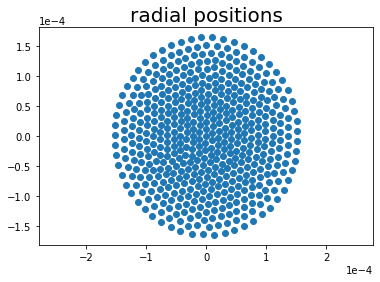

In [57]:
%matplotlib inline
#plot x and y in rotating frame
ax = plt.subplot()
step = 1000 #between start_step and end_step
ax.plot(pos_rot[step, 0, :], pos_rot[step, 1, :], 'o')
ax.axis('equal')
ax.set_title('radial positions', fontsize=20)
ax.tick_params(axis='both', labelsize=10)
ax.xaxis.offsetText.set_fontsize(10)
ax.yaxis.offsetText.set_fontsize(10)
ax.ticklabel_format(style='sci', scilimits = (0,0))

In [58]:
#Rotating frame animation
from matplotlib.animation import FuncAnimation

class animate:
    def __init__(self,posall,units=1e6, title = "Title"):
        max_slices = 10**5
        len_slices = np.size(posall[:,0,0])
        if len_slices<max_slices: 
            sl=len_slices
        else: 
            sl=max_slices
        
        self.posall = posall


        self.x = []
        self.y = []

        self.positions1 = self.posall*units


        self.figure, self.ax = plt.subplots(figsize=(12,12))
        self.lim = np.max(np.abs(posall[0,:,:]*units))*1.2
        self.points1, = self.ax.plot(self.x, self.y
                                    ,'bo'
                                    ,zorder=2
                                    ,label='Particle'
                                    ,markersize=5)
        self.lines1, = self.ax.plot(self.x, self.y
                ,'ro'
                ,zorder=1
                ,label='Trail'
                ,markersize=0.1)
        self.ax.legend()
        plt.title(title)
        self.ax.set_xlabel(r'x [$\mu m$]')
        self.ax.set_ylabel(r'y [$\mu m$]')
        self.ax.set_aspect(1)

    def func_animate(self,frame_number,skip=100,tail=10**3,dots_every=1):
        self.ax.set_ylim((-self.lim,self.lim))
        self.ax.set_xlim((-self.lim,self.lim))
        x1 = self.positions1[frame_number*skip,0,:]
        y1 = self.positions1[frame_number*skip,1,:]
        if frame_number*skip-tail >= 0:
            index = np.arange(frame_number*skip-tail,
                                frame_number*skip,
                                dots_every)
            linex1=self.positions1[index,0,:]
            liney1=self.positions1[index,1,:]
        else:
            index = np.arange(0,frame_number*skip,dots_every)
            linex1=self.positions1[index,0,:]
            liney1=self.positions1[index,1,:]

        thetime = 1e-8*float(frame_number*skip)/1e-6
        #self.ax.annotate(r"Time =%1.0f[$\mu s$]" %thetime, xy=(0.1, 0.04),\
        #            xycoords='axes fraction',size=10,\
        #            bbox=dict(boxstyle='round', fc='w'))
        self.points1.set_data(x1,y1)
        self.lines1.set_data(linex1,liney1)

<IPython.core.display.Javascript object>


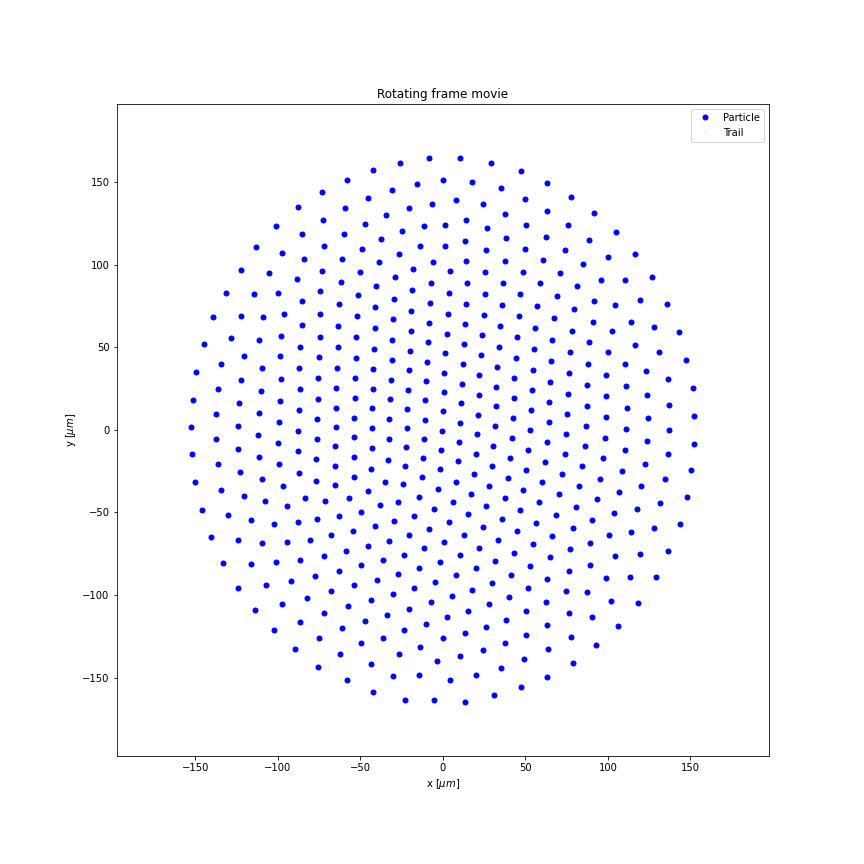

IndexError: index 5100 is out of bounds for axis 0 with size 5002

In [59]:
%matplotlib notebook
from matplotlib.animation import FFMpegWriter

rot_anim = animate(pos_rot, title = "Rotating frame movie")
#for i in range(1000):
#    this_anim.func_animate(i)
#ani_rot = FuncAnimation(
#    rot_anim.figure, rot_anim.func_animate, interval=1, save_count = 100, repeat = False)
ani_rot = FuncAnimation(
    rot_anim.figure, rot_anim.func_animate, frames =4000, interval=10)
writervideo = FFMpegWriter(fps=60)
ani_rot.save('rotating_4000frames_test.mp4', writer=writervideo)


<IPython.core.display.Javascript object>


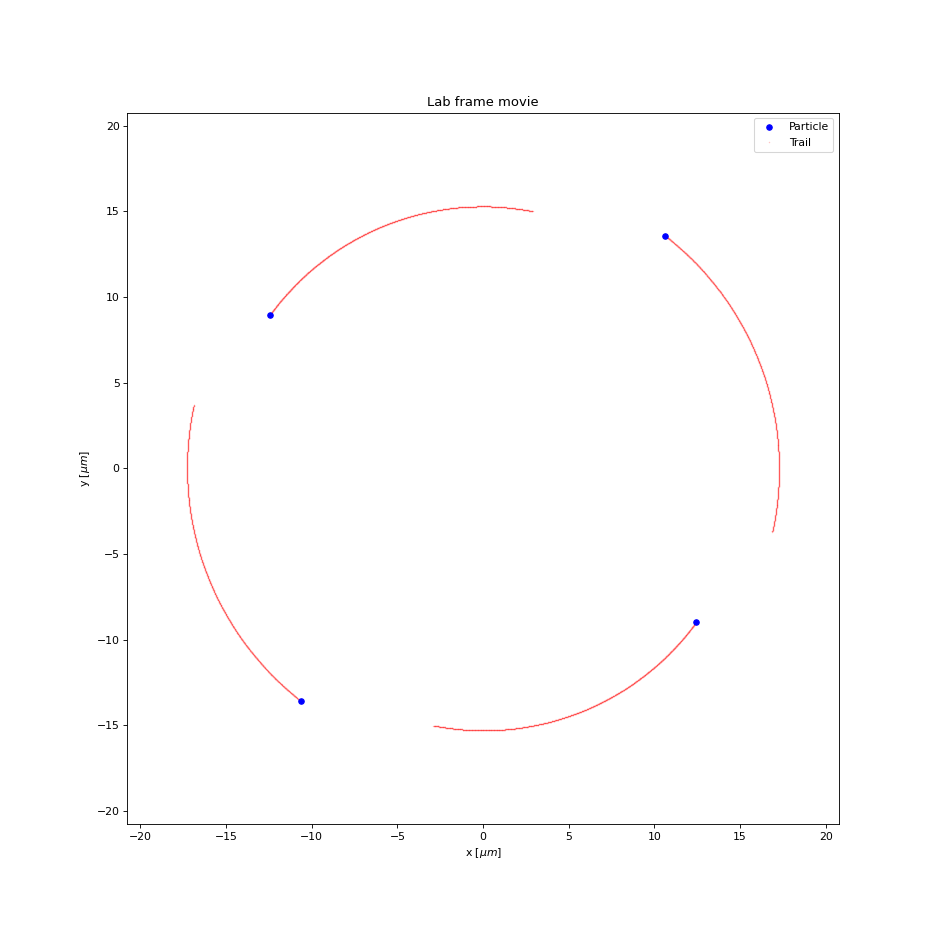

In [163]:
pos_lab = data[:, 0:2, :]
lab_anim = animate(pos_lab, title="Lab frame movie")
#for i in range(1000):
#    this_anim.func_animate(i)
ani_lab = FuncAnimation(
    lab_anim.figure, lab_anim.func_animate, frames = 4000, interval=10)
writervideo = FFMpegWriter(fps=60)
ani_lab.save('lab_4000frames_no_pert.mp4', writer=writervideo)

In [ ]:
%matplotlib notebook
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

# creating a blank window
# for the animation
fig = plt.figure()
xmin = -0.3*10**-8-4*10**-3
xmax = 0.3*10**-8-4*10**-3
ymin = 0*10**-9
ymax = 4.2*10**-9
axis = plt.axes(xlim =(xmin,xmax),
                ylim =(ymin,ymax))
 
line, = axis.plot([], [], lw = 0.1)
 
# what will our line dataset
# contain?
def init():
    line.set_data([], [])
    return line,
 
# initializing empty values
# for x and y co-ordinates
xdata, ydata = [], []

# animation function
def animate(i):
    x = data[i,0,0]
    y = data[i,1,0]     
    xdata.append(x)
    ydata.append(y)
    line.set_data(xdata, ydata)
     
    return line,

# calling the animation function    
anim = animation.FuncAnimation(fig, animate,
                            init_func = init,
                            frames = 200,
                            interval = 100,
                            blit = True)
 
# saves the animation in our desktop
#anim.save('growingCoil.mp4', writer = 'ffmpeg', fps = 30)

In [ ]:
%matplotlib notebook
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

# creating a blank window
# for the animation
fig = plt.figure()
xmin = -2.5*10**-9+4.058*10**-4
xmax = 1.6*10**-9+4.058*10**-4
ymin = 0
ymax = 1*10**-7
axis = plt.axes(xlim =(xmin,xmax),
                ylim =(ymin,ymax))
 
line, = axis.plot([], [], lw = 0.1)
 
# what will our line dataset
# contain?
def init():
    line.set_data([], [])
    return line,
 
# initializing empty values
# for x and y co-ordinates
xdata, ydata = [], []

# animation function
def animate(i):
    x = data[i,0,1]
    y = data[i,1,1]     
    xdata.append(x)
    ydata.append(y)
    line.set_data(xdata, ydata)
     
    return line,

# calling the animation function    
anim = animation.FuncAnimation(fig, animate,
                            init_func = init,
                            frames = 200,
                            interval = 20,
                            blit = True)
 
# saves the animation in our desktop
#anim.save('growingCoil.mp4', writer = 'ffmpeg', fps = 30)

In [274]:
#Initialize mode analysis with same parameters as in set_parameters
num_ions=6
mass_amu=9.012182
#mass_amu = 138
vtrap=(0.0, -1750.0, -1970.0)
v_wall=1.
frot=180000
method='bfgs'
frot_kHz = 1e-3*frot 
units = 1e6
ma_instance=ma.ModeAnalysis(
            N      = num_ions,
            ionmass= mass_amu,
            Vtrap  = vtrap,
            Vwall  = v_wall,
            frot   = frot_kHz,
            method = method)
ma_instance.run()


all_normal_freqs = ma_instance.planarEvalsE/units/2/np.pi
ax_normal_freqs = ma_instance.axialEvalsE/units/2/np.pi

print(ax_normal_freqs)


11
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.25146481]


<IPython.core.display.Javascript object>


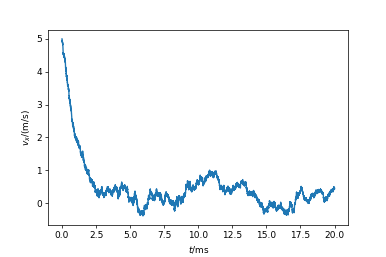

Final velcoity in x-direction: 0.4584703


In [59]:
times = []
for i in range(len(data)):
    times.append(i*dt)
plt.figure()
plt.plot(1.0e3 * np.array(times), data[:,3,0])
plt.xlabel(r'$t/\rm{ms}$')
plt.ylabel(r'$v_x/(\rm{m}/\rm{s})$')
print("Final velcoity in x-direction: " + str(data[-1,3,0]))